# 청년 순이동률 분석
## TOP 5를 선정
***순이동률 : 전입 - 전출***

In [2]:
import pandas as pd
import requests
import numpy as np

import koreanize_matplotlib
import matplotlib.pyplot as plt

# pd.set_option("display.max_rows", 1000)

admin = pd.read_csv("../../data/행정구역코드.csv")
admin["행정구역코드"] = admin["행정구역코드"].astype(str)

# 수도권 + 광역시 제외
exclude_prefix = ["11", "31", "21", "22", "23", "24", "25", "26"]
sigun = admin[~admin["행정구역코드"].str[:2].isin(exclude_prefix)].copy()

objL1 = "+".join(sigun["행정구역코드"].tolist()) + "+"

In [3]:
BASE_URL = "https://kosis.kr/openapi/Param/statisticsParameterData.do"

params = {
    "method": "getList",
    "apiKey": "ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    "orgId": "101",
    "tblId": "DT_1YL20642",
    "itmId": "T001+",
    "objL1": objL1,
    "objL2": "21+22+23+",
    "format": "json",
    "jsonVD": "Y",
    "prdSe": "Y",
    "newEstPrdCnt": "3"
}

response = requests.get(BASE_URL, params=params)
df_raw = pd.DataFrame(response.json())

In [4]:
df = df_raw[[
    "PRD_DE",   # 연도
    "C1",       # 행정코드
    "C1_NM",    # 지역명
    "C2_NM",    # 지표명 (순이동률 / 순이동)
    "DT"        # 값
]].copy()

df.columns = ["연도", "행정코드", "지역명", "지표", "값"]

df["연도"] = df["연도"].astype(int)
df["행정코드"] = df["행정코드"].astype(str)
df["값"] = pd.to_numeric(df["값"], errors="coerce")

rate_df = df[df["지표"].str.contains("순이동률")].copy()
count_df = df[df["지표"].str.contains("순이동") & ~df["지표"].str.contains("률")].copy()

rate_df.rename(columns={"값": "청년순이동률"}, inplace=True)
count_df.rename(columns={"값": "청년순이동"}, inplace=True)

pivot_rate_df = (
    rate_df.pivot_table(
        index=["행정코드", "지역명"],
        columns="연도",
        values="청년순이동률",
        aggfunc="sum"
    )
    .reset_index()
)

pivot_count_df = (
    count_df.pivot_table(
        index=["행정코드", "지역명"],
        columns="연도",
        values="청년순이동",
        aggfunc="sum"
    )
    .reset_index()
)

## 선별 로직, "증가의 정의"
### 가중 추세 점수 (Weighted Trend Score)
- 추세 기울기 (방향성)
  * 2022 → 2023 → 2024 가 전체적으로 증가인가?
  * 선형회귀 기울기 사용
- 최근 가중 평균 (레벨)
  * “최근일수록 중요”하다는 가정
- 변동성 페널티 (안정성)
  * 변동성 클수록 점수 ↓
  * 표준편차 사용

### 최종 수식 : 
TOP5_SCORE =
  (추세_기울기 × α)
+ (최근가중평균 × β)
- (표준편차 × γ)

### TOP5 선정이 “무슨 지역”을 뽑게 되는가?
- 최근 1년 순이동률이 높거나(가중치 0.5 영향)
- 최근 3년 기울기가 양수로 증가 추세이고
- 최근 3년 변동성이 낮은(안정적) 지역

**즉, “최근에 잘 들어오고 + 더 좋아지고 있으며 + 들쭉날쭉하지 않은” 지역을 TOP5으로 뽑게 됩니다.**

In [ ]:
import numpy as np
import pandas as pd

# =========================
# 0) 입력: pivot_rate_df (행정코드, 지역명, 연도컬럼들)
# =========================

# 최근 3개 연도 자동 선택 (newEstPrdCnt=3이지만 혹시 더 들어와도 안전)
year_cols = sorted([c for c in pivot_rate_df.columns if isinstance(c, (int, np.integer))])
target_years = year_cols[-3:]  # 예: [2022, 2023, 2024]

# 가중치(최근일수록 중요)
w = np.array([0.2, 0.3, 0.5], dtype=float)
w = w / w.sum()

# 점수 가중치 (프로젝트용 기본값)
alpha = 0.4  # slope (방향성)
beta  = 0.5  # weighted_mean (최근 수준)
gamma = 0.1  # std (변동성 페널티)

score_df = pivot_rate_df[["행정코드", "지역명"] + target_years].copy()
y = score_df[target_years].to_numpy(dtype=float)

# =========================
# 1) 추세 기울기(slope): 선형회귀의 기울기
#    x = [0,1,2]로 고정 (연도 간격 동일 가정)
# =========================
x = np.arange(len(target_years), dtype=float)
x_centered = x - x.mean()
x_denom = (x_centered**2).sum()

# slope = cov(x,y)/var(x) (row-wise)
y_centered = y - np.nanmean(y, axis=1, keepdims=True)
slope = np.nansum(x_centered * y_centered, axis=1) / x_denom

# =========================
# 2) 최근가중평균(weighted mean)
# =========================
weighted_mean = np.nansum(y * w, axis=1)

# =========================
# 3) 변동성(std)
# =========================
std = np.nanstd(y, axis=1)

score_df["slope"] = slope
score_df["weighted_mean"] = weighted_mean
score_df["std"] = std

# =========================
# 4) 스케일 보정: z-score 표준화 (권장)
#    - slope, weighted_mean, std의 단위/범위가 다를 수 있음
# =========================
for col in ["slope", "weighted_mean", "std"]:
    mu = score_df[col].mean(skipna=True)
    sd = score_df[col].std(skipna=True)
    score_df[f"z_{col}"] = (score_df[col] - mu) / (sd if sd != 0 else 1)

# 최종 점수
score_df["top5_score"] = (
    alpha * score_df["z_slope"]
    + beta * score_df["z_weighted_mean"]
    - gamma * score_df["z_std"]
)

# =========================
# 5) 필터: "증가"의 최소 조건
#    옵션 A: 최신년도 > 0 (가장 강한 필터)
#    옵션 B: 최근 2년 평균 > 0 (조금 완화)
# =========================
latest_year = target_years[-1]
recent2_mean = score_df[target_years[-2:]].mean(axis=1)

# 원하는 필터 하나 선택해서 쓰면 됨
score_df_filtered = score_df[
    (score_df[latest_year] > 0) & (recent2_mean > 0)
].copy()

# =========================
# 6) TOP5 뽑기 + 보기 좋게 정렬
# =========================
top5 = (
    score_df_filtered
    .sort_values("top5_score", ascending=False)
    .head(5)
    [["행정코드", "지역명"] + target_years + ["slope", "weighted_mean", "std", "top5_score"]]
)


## TOP 5 선정

In [6]:
display(top5)

연도,행정코드,지역명,2022,2023,2024,slope,weighted_mean,std,top5_score
32,34040,아산시,4.8,5.7,5.4,0.30,5.37,0.374166,1.712142
73,36620,무안군,-0.5,0.0,4.4,2.45,2.10,2.201515,1.549272
83,37040,안동시,-3.9,-2.3,3.6,3.75,0.33,3.225248,1.495004
50,35510,완주군,3.3,11.3,3.7,0.20,5.90,3.680580,1.376761
41,34560,홍성군,-2.7,-1.8,3.1,2.90,0.47,2.548638,1.361984
36,34080,당진시,0.3,1.4,1.9,0.80,1.43,0.668331,1.160565


## TOP5 막대 그래프

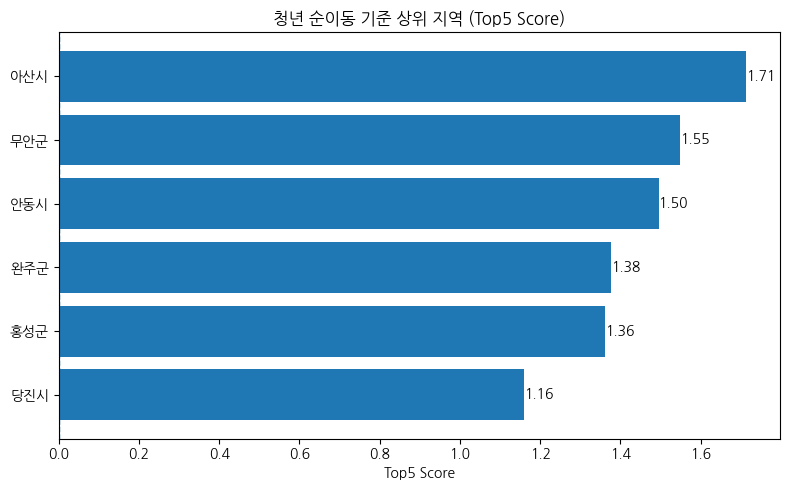

In [7]:
plot_bar_df = (
    top5
    .sort_values("top5_score", ascending=True)  # 가로막대는 아래→위 정렬이 보기 좋음
)

plt.figure(figsize=(8, 5))

plt.barh(
    plot_bar_df["지역명"],
    plot_bar_df["top5_score"]
)

plt.axvline(0, linewidth=1, linestyle="--")

plt.xlabel("Top5 Score")
plt.ylabel("")
plt.title("청년 순이동 기준 상위 지역 (Top5 Score)")

# 점수 값 표시
for i, v in enumerate(plot_bar_df["top5_score"]):
    plt.text(v, i, f"{v:.2f}", va="center")

plt.tight_layout()
plt.show()


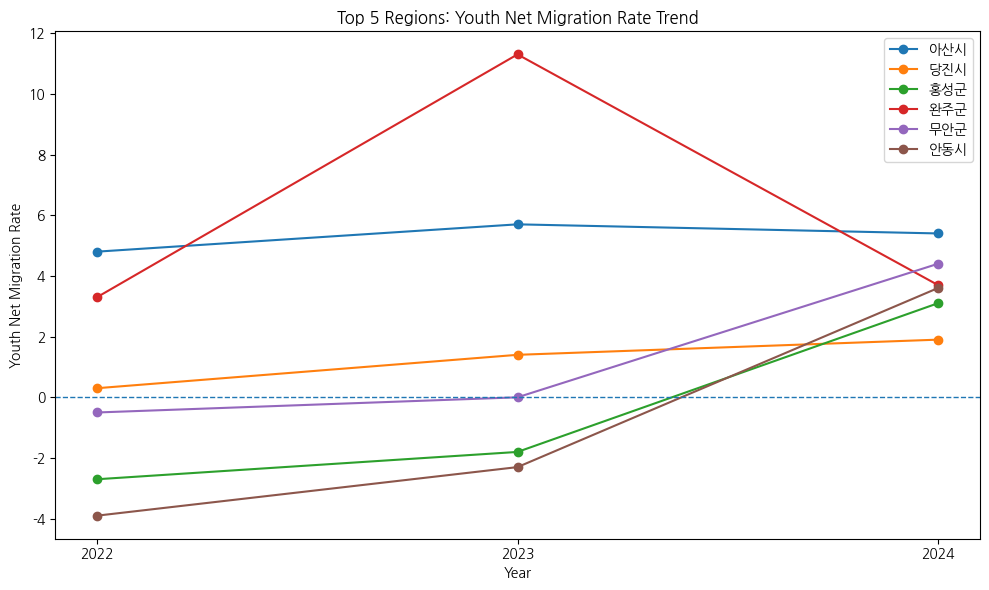

In [8]:
# 1) top5 지역 코드 목록 (top5 DF에 '행정코드'가 있다고 가정)
top5_codes = top5["행정코드"].astype(str).tolist()

# 2) plot용 DF 만들기
plot_df = pivot_rate_df.copy()
plot_df["행정코드"] = plot_df["행정코드"].astype(str)
plot_df = plot_df[plot_df["행정코드"].isin(top5_codes)].copy()

# 3) 선그래프
plt.figure(figsize=(10, 6))
for _, row in plot_df.iterrows():
    y = row[year_cols].astype(float).values
    plt.plot(year_cols, y, marker="o", label=row["지역명"])

plt.axhline(0, linewidth=1, linestyle="--")
plt.xticks(year_cols)
plt.xlabel("Year")
plt.ylabel("Youth Net Migration Rate")
plt.title("Top 5 Regions: Youth Net Migration Rate Trend")
plt.legend()
plt.tight_layout()
plt.show()

# 참고 자료
## 완주군(전북특별자치도)
- https://www.wj1news.com/news/article.html?no=6080
- https://www.yna.co.kr/view/AKR20251110038300055
- https://youth.wanju.go.kr/index.wanju
- https://www.youtube.com/watch?v=FVFRVGSvkq0

## 안동
- https://www.joongang.co.kr/article/25342512
- https://www.youtube.com/watch?v=mRDSCpXdoOM
- https://dgmbc.com/NewsArticle/629968

---

# 🔽 HISTORY

In [9]:
year_cols = [
    col for col in pivot_rate_df.columns
    if isinstance(col, int)
]

# 단순 평균
pivot_rate_df["평균"] = (
    pivot_rate_df[year_cols].mean(axis=1)
)

# 중앙값
pivot_rate_df["중앙값"] = (
    pivot_rate_df[year_cols].median(axis=1)
)

n = len(year_cols)
mid = n // 2

pivot_rate_df["증가율"] = (pivot_rate_df[year_cols[mid:]].mean(axis=1) - pivot_rate_df[year_cols[:mid]].mean(axis=1))

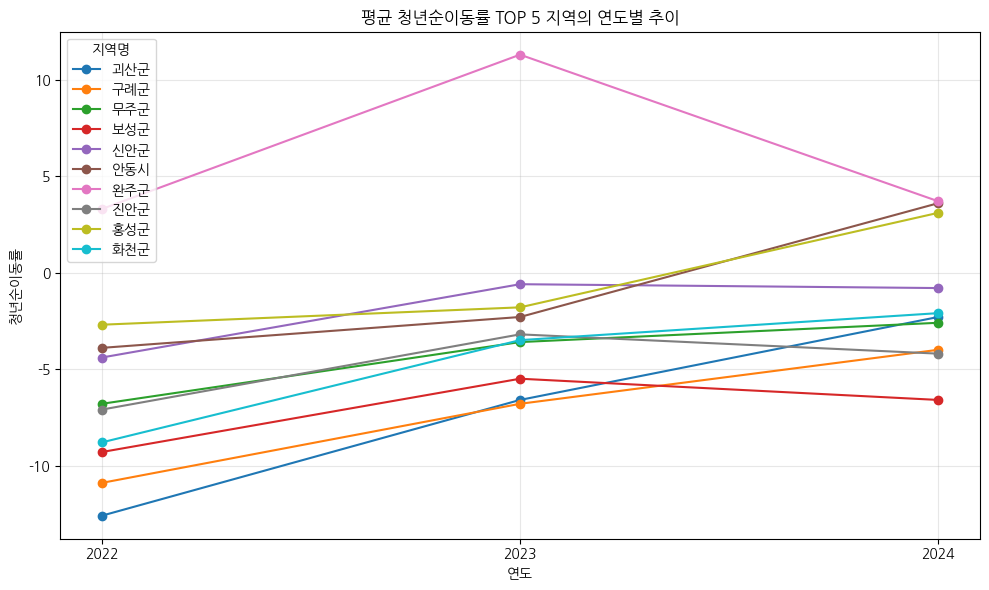

연도,행정코드,지역명,증가율
25,33560,괴산군,8.15
13,32570,화천군,6.00
65,36530,구례군,5.50
83,37040,안동시,4.55
50,35510,완주군,4.20
79,36680,신안군,3.70
52,35530,무주군,3.70
51,35520,진안군,3.40
41,34560,홍성군,3.35
67,36560,보성군,3.25


In [10]:
year_cols = sorted([c for c in pivot_rate_df.columns if isinstance(c, int)])


# 2) 평균 TOP 5 지역 선택
top5 = (
    pivot_rate_df
    .sort_values("증가율", ascending=False)
    .head(10)
    .copy()
)

# 3) long 형태로 변환 (그래프용)
plot_df = top5.melt(
    id_vars=["행정코드", "지역명", "증가율"],
    value_vars=year_cols,
    var_name="연도",
    value_name="청년순이동률"
).sort_values(["지역명", "연도"])

# 4) 선 그래프 (기본 컬러 사이클로 지역별 자동 색상)
plt.figure(figsize=(10, 6))
for region, g in plot_df.groupby("지역명"):
    plt.plot(g["연도"], g["청년순이동률"], marker="o", label=region)

plt.xticks(year_cols)
plt.xlabel("연도")
plt.ylabel("청년순이동률")
plt.title("평균 청년순이동률 TOP 5 지역의 연도별 추이")
plt.grid(True, alpha=0.3)
plt.legend(title="지역명")
plt.tight_layout()
plt.show()

top5[["행정코드", "지역명", "증가율"]]


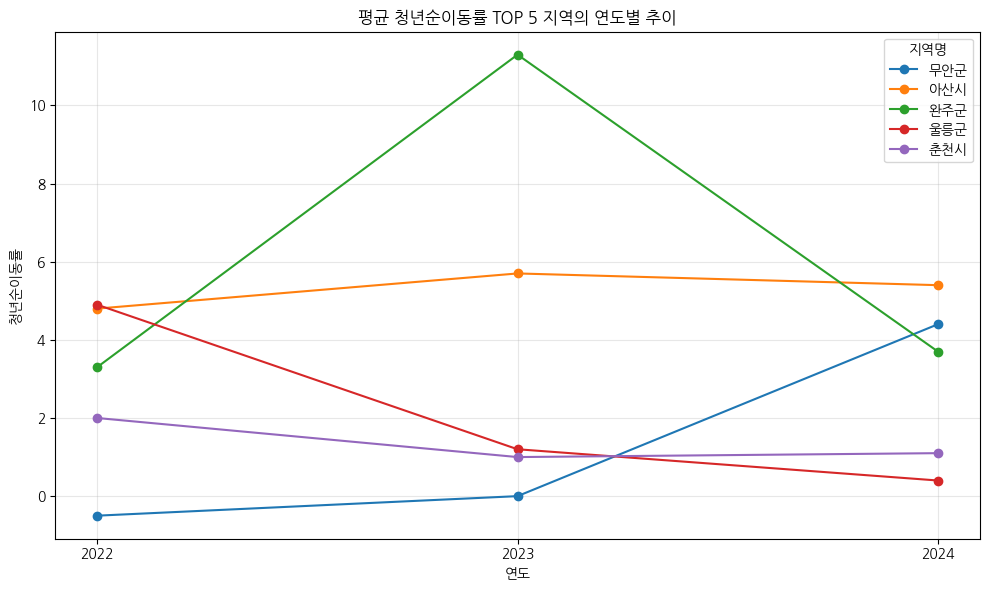

연도,행정코드,지역명,평균
50,35510,완주군,6.100000
32,34040,아산시,5.300000
101,37630,울릉군,2.166667
0,32010,춘천시,1.366667
73,36620,무안군,1.300000


In [11]:
import koreanize_matplotlib
import matplotlib.pyplot as plt

year_cols = sorted([c for c in pivot_rate_df.columns if isinstance(c, int)])


# 2) 평균 TOP 5 지역 선택
top5 = (
    pivot_rate_df
    .sort_values("평균", ascending=False)
    .head(5)
    .copy()
)

# 3) long 형태로 변환 (그래프용)
plot_df = top5.melt(
    id_vars=["행정코드", "지역명", "평균"],
    value_vars=year_cols,
    var_name="연도",
    value_name="청년순이동률"
).sort_values(["지역명", "연도"])

# 4) 선 그래프 (기본 컬러 사이클로 지역별 자동 색상)
plt.figure(figsize=(10, 6))
for region, g in plot_df.groupby("지역명"):
    plt.plot(g["연도"], g["청년순이동률"], marker="o", label=region)

plt.xticks(year_cols)
plt.xlabel("연도")
plt.ylabel("청년순이동률")
plt.title("평균 청년순이동률 TOP 5 지역의 연도별 추이")
plt.grid(True, alpha=0.3)
plt.legend(title="지역명")
plt.tight_layout()
plt.show()

top5[["행정코드", "지역명", "평균"]]


In [12]:
employment_objL1 = "+".join(sigun["행정구역코드"].str.rstrip("0").tolist()) + "+"

employment_params = {
    "method": "getList",
    "apiKey": "ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    "itmId": "T00+T12+",
    "objL1": "3404+3436+3531+3642+3704+3408+",
    "objL2": "010+",
    "objL3": "",
    "objL4": "",
    "objL5": "",
    "objL6": "",
    "objL7": "",
    "objL8": "",
    "format": "json",
    "jsonVD": "Y",
    "prdSe": "H",
    "newEstPrdCnt": "7",
    "orgId": "101",
    "tblId":"DT_1ES3A03_A01S"
}

response = requests.get(BASE_URL, params=employment_params)
employment_raw = pd.DataFrame(response.json())

In [13]:
# response = requests.get(BASE_URL, params=employment_params)
# employment_raw = pd.DataFrame(response.json())

pd.set_option("display.max_rows", 200)

# 1) 필요한 컬럼만 정리 (PRD_DE가 반드시 있어야 함)
keep_cols = ["PRD_DE", "C1", "C1_NM", "C2_NM", "ITM_ID", "ITM_NM", "DT"]
missing = [c for c in keep_cols if c not in employment_raw.columns]
if missing:
    raise ValueError(f"employment_raw에 필요한 컬럼이 없습니다: {missing}")

emp = employment_raw[keep_cols].copy()
emp.columns = ["기간", "행정코드", "지역명", "연령대", "지표코드", "지표명", "값"]

emp["행정코드"] = emp["행정코드"].astype(str)
emp["기간"] = emp["기간"].astype(str)
emp["연령대"] = emp["연령대"].astype(str)
emp["지표코드"] = emp["지표코드"].astype(str)
emp["값"] = pd.to_numeric(emp["값"], errors="coerce")

# 2) 기간 포맷 정리 (예: '2024-01', '2023-08' 같은 형태로 맞추기)
# KOSIS가 '2024.01' 같이 줄 때도 있어서 통일
emp["기간"] = (
    emp["기간"]
    .str.replace(".", "-", regex=False)
    .str.strip()
)

# 3) 지표 분리
# - T00: 취업자(천명)
# - T12: 고용률(%)
emp_persons = emp[emp["지표코드"] == "T00"].copy()
emp_rate = emp[emp["지표코드"] == "T12"].copy()

# 4) 원하는 wide 형태로 pivot
# index: (행정코드, 지역명, 연령대)
# columns: 기간(YYYY-MM)
# values: 값
pivot_employed_persons = (
    emp_persons
    .pivot_table(
        index=["행정코드", "지역명", "연령대"],
        columns="기간",
        values="값",
        aggfunc="mean"  # 동일 키 중복 시 평균(보통 중복 없어야 정상)
    )
    .reset_index()
)

pivot_employment_rate = (
    emp_rate
    .pivot_table(
        index=["행정코드", "지역명", "연령대"],
        columns="기간",
        values="값",
        aggfunc="mean"
    )
    .reset_index()
)

# 5) 컬럼 정렬: 기간 컬럼을 시간순으로 정렬
def sort_period_cols(df):
    base_cols = ["행정코드", "지역명", "연령대"]
    period_cols = [c for c in df.columns if c not in base_cols]
    period_cols_sorted = sorted(period_cols)  # YYYY-MM이면 문자열 정렬로 시간순 OK
    return df[base_cols + period_cols_sorted]

pivot_employed_persons = sort_period_cols(pivot_employed_persons)
pivot_employment_rate = sort_period_cols(pivot_employment_rate)


display(top5)
display(pivot_employed_persons)


연도,행정코드,지역명,2022,2023,2024,평균,중앙값,증가율
50,35510,완주군,3.3,11.3,3.7,6.100000,3.7,4.20
32,34040,아산시,4.8,5.7,5.4,5.300000,5.4,0.75
101,37630,울릉군,4.9,1.2,0.4,2.166667,1.2,-4.10
0,32010,춘천시,2.0,1.0,1.1,1.366667,1.1,-0.95
73,36620,무안군,-0.5,0.0,4.4,1.300000,0.0,2.70


기간,행정코드,지역명,연령대,202201,202202,202301,202302,202401,202402,202501
0,3404,아산시,15 - 29세,28.8,27.8,30.6,30.3,30.3,30.5,32.1
1,3408,당진시,15 - 29세,9.1,9.7,9.9,9.9,9.8,9.2,10.5
2,3436,홍성군,15 - 29세,6.3,6.7,5.7,4.4,5.4,5.5,5.4
3,3531,완주군,15 - 29세,4.6,7.0,6.6,7.4,6.5,5.6,5.7
4,3642,무안군,15 - 29세,3.8,4.6,4.9,4.1,5.6,5.8,6.1
5,3704,안동시,15 - 29세,7.1,8.5,9.5,9.7,8.7,8.0,7.5


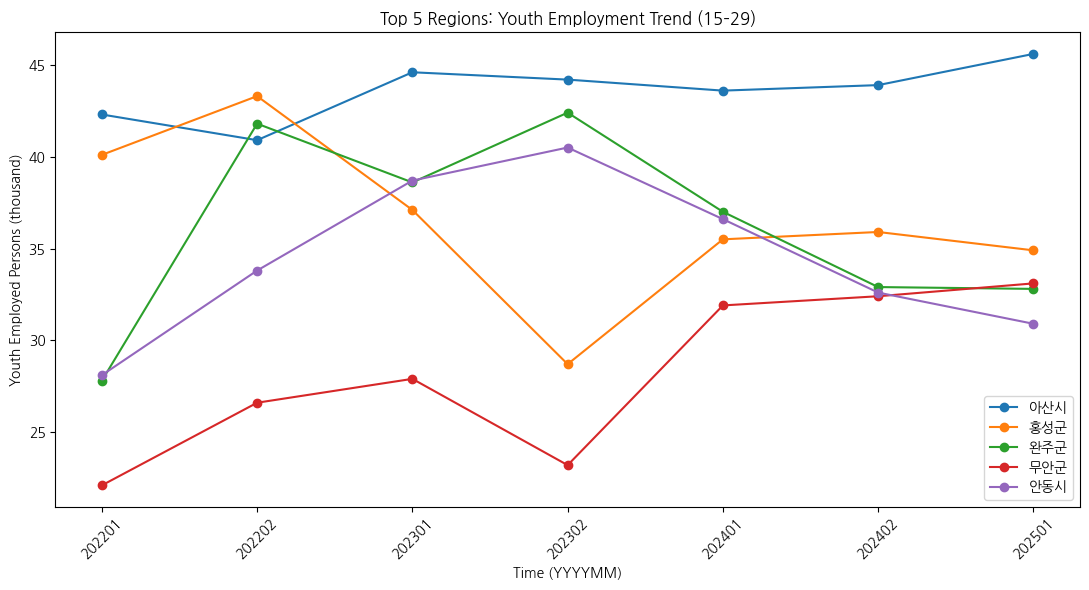

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# plot 대상 DF
plot_df = pivot_employment_rate.loc[~(pivot_employment_rate['지역명'] == '당진시')].copy()

# 기간 컬럼 자동 추출 (숫자형 YYYYMM)
time_cols = sorted([c for c in plot_df.columns if str(c).isdigit()])

plt.figure(figsize=(11, 6))

for _, row in plot_df.iterrows():
    y = row[time_cols].astype(float).values
    plt.plot(time_cols, y, marker="o", label=row["지역명"])

plt.xlabel("Time (YYYYMM)")
plt.ylabel("Youth Employed Persons (thousand)")
plt.title("Top 5 Regions: Youth Employment Trend (15–29)")
plt.xticks(time_cols, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
